#### Import Dataset 

In [ ]:
import numpy as np 
import torch 
from torchvision import datasets, transforms 

# transforms -- changes numpy to tensor 
trainset = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
valset = datasets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
testset = datasets.MNIST(root='./data', train = False, download = True, transform = transforms.ToTensor()) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Split & Prepare Dataset

In [ ]:
val_ratio = 0.1 
train_data, val_data = torch.utils.data.random_split(trainset, (int(len(trainset)*(1-val_ratio)), int(len(trainset)*val_ratio)))

#### Building the MLP Model 

In [ ]:
class TwoLayerMLP(torch.nn.Module): 
  def __init__(self): 
    super(TwoLayerMLP, self).__init__() 
    self.input_layer = torch.nn.Linear(784, 256)    # .cuda()
    self.first_layer = torch.nn.Linear(256, 256)   # .cuda()
    self.second_layer = torch.nn.Linear(256, 10)   # .cuda() 

  def forward(self, x):
    input_one = torch.nn.functional.relu(self.input_layer(x))
    hidden_one = torch.nn.functional.relu(self.first_layer(input_one))
    y_pred = self.second_layer(hidden_one) 
    # y_pred = torch.nn.functional.softmax(self.second_layer(hidden_one), dim=1) 
    # -- crossEntropyLoss function already contains softmax 
    return y_pred 


In [ ]:
def train_function(num_epochs, train_data): 
   
  model = TwoLayerMLP() 
  optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2) 
  loss_function = torch.nn.CrossEntropyLoss() 

  batch_losses = [] 
  epoch_losses = []
  for epoch in range(num_epochs): 
    model = model.train() 
    train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 64) 
    # shuffles train data before every epoch 
    
    for count, (input_data, labels) in enumerate(train_loader):  

      # reshape the data 
      input_data = input_data.view(input_data.size(0), -1)
      labels = labels  # .cuda 

      # feed data into model and calculate loss function 
      y_pred = model(input_data)  # do not put argmax here! 
                                  # -- argmax is not differentiable and would not train the model! 
      loss = loss_function(y_pred, labels)

      # backpropagate the calculated loss and update weights 
      loss.backward() 
      batch_losses.append(loss)  # keeps track of loss for each batch 
      optimizer.step() 
      optimizer.zero_grad() 
    print('Epoch: {} | Loss: {}\n'.format(epoch, loss))
    epoch_losses.append(loss)
  return epoch_losses, batch_losses, model, loss_function 
    


#### Training the MLP Model 

In [ ]:
epoch_losses, batch_losses, trained_model, loss_function = train_function(5, train_data)

Epoch: 0 | Loss: 0.8850622177124023



#### Feeding Validation data into Trained Model 

In [ ]:
def test_function(test_data, trained_model, loss_function): 
  predicted = [] 
  actual = [] 
  for count, (input_data, labels) in enumerate(test_data): 
    # input_data = input_data.float() / 255 
    # -- dont need this line as input_data is already transformed to tensor in data loader 
    input_data = input_data.view(input_data.size(0), -1)
    y_pred = trained_model(input_data) 
    y = y_pred.tolist() 
    actual.append(labels)
    for i in y: 
      predicted.append(i.index(max(i)))
  return predicted, actual 

In [ ]:
predicted_val, actual_val = test_function(val_data, trained_model, loss_function)
print(predicted_val) 
print(actual_val)

[6, 9, 1, 8, 8, 3, 2, 3, 2, 9, 2, 7, 8, 0, 3, 8, 3, 3, 7, 2, 0, 1, 0, 0, 3, 6, 8, 2, 7, 4, 0, 3, 1, 2, 0, 7, 5, 4, 9, 1, 8, 8, 1, 3, 8, 8, 4, 4, 7, 7, 6, 4, 5, 0, 2, 5, 3, 3, 7, 3, 9, 5, 1, 7, 9, 7, 1, 4, 6, 2, 4, 2, 4, 6, 9, 2, 1, 5, 0, 6, 3, 6, 3, 0, 9, 3, 9, 1, 2, 1, 8, 7, 5, 6, 4, 4, 3, 7, 0, 2, 5, 7, 6, 8, 0, 8, 2, 6, 1, 1, 3, 1, 4, 2, 1, 0, 6, 7, 7, 6, 0, 0, 3, 7, 3, 5, 0, 2, 7, 3, 1, 6, 0, 9, 2, 8, 0, 6, 1, 1, 3, 0, 3, 8, 0, 3, 6, 3, 9, 0, 6, 8, 3, 5, 8, 7, 2, 1, 0, 0, 4, 7, 3, 7, 0, 8, 4, 7, 5, 1, 9, 4, 1, 9, 4, 0, 2, 7, 1, 1, 8, 6, 3, 4, 7, 3, 3, 1, 2, 5, 7, 0, 3, 8, 3, 6, 6, 7, 9, 9, 8, 0, 0, 2, 3, 1, 9, 3, 1, 5, 7, 1, 7, 7, 2, 9, 6, 3, 0, 7, 3, 9, 6, 8, 1, 6, 9, 9, 4, 3, 9, 1, 6, 8, 1, 1, 6, 1, 7, 3, 0, 3, 6, 7, 3, 5, 0, 7, 0, 6, 6, 1, 9, 1, 2, 8, 4, 2, 8, 9, 2, 4, 0, 0, 4, 1, 1, 8, 3, 8, 4, 1, 8, 7, 9, 3, 1, 3, 6, 9, 1, 1, 1, 7, 1, 6, 2, 8, 2, 4, 3, 8, 1, 4, 9, 8, 0, 4, 7, 2, 9, 3, 5, 6, 6, 7, 3, 0, 0, 2, 9, 1, 7, 5, 1, 4, 2, 0, 7, 4, 9, 7, 6, 7, 1, 2, 1, 7, 6, 9, 2, 3, 4, 

#### Calculate Accuracy 

In [ ]:
def accuracy(predicted_labels, true_labels): 
  correct = 0 
  for idx in range(len(predicted_labels)): 
    if predicted_labels[idx] == true_labels[idx]: 
      correct += 1 
  accuracyVal = correct / len(true_labels) * 100 
  return accuracyVal 

accuracyVal = accuracy(predicted_val, actual_val)
print(accuracyVal)

80.4


#### Driver Code to find number of Epochs 
(for good generalisation)

In [ ]:
def driver_epoch(train_data, val_data): 
  for num_epochs in [5, 10, 20, 30, 40, 50]: 
    epoch_losses, batch_losses, trained_model, loss_function = train_function(num_epochs, train_data) 
    predicted_val, actual_val = test_function(val_data, trained_model, loss_function) 
    accuracyValue = accuracy(predicted_val, actual_val) 
    print('number of epochs: {} | accuracy: {} '.format(num_epochs, accuracyValue))

val_ratio = 0.1 
train_data, val_data = torch.utils.data.random_split(trainset, (int(len(trainset)*(1-val_ratio)), int(len(trainset)*val_ratio)))
driver_epoch(train_data, val_data)


number of epochs: 5 | accuracy: 91.10000000000001 
number of epochs: 10 | accuracy: 93.21666666666667 
number of epochs: 20 | accuracy: 95.91666666666666 
number of epochs: 30 | accuracy: 96.65 
number of epochs: 40 | accuracy: 97.28333333333333 
number of epochs: 50 | accuracy: 97.56666666666666 


In [ ]:
epoch_losses, batch_losses, trained_model, loss_function = train_function(50, train_data)

NameError: ignored

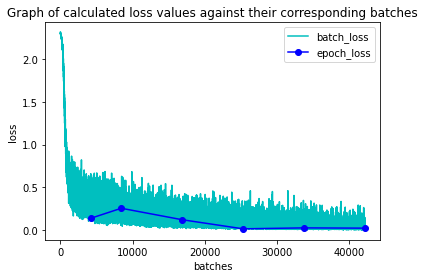

In [ ]:
import matplotlib.pyplot as plt 
batch_losses_val_y = [] 
epoch_losses_val_y = [] 
epochs = [5, 10, 20, 30, 40, 50]
epoch_losses_val_x = []
for ele in batch_losses: 
  batch_losses_val_y.append(ele.item()) 
batch_losses_val_x = [i for i in range(1, len(batch_losses) +1)]
for idx in epochs: 
  val = (idx)*844 -1
  epoch_losses_val_x.append(val)
  epoch_losses_val_y.append(batch_losses_val_y[val])
plt.plot(batch_losses_val_x, batch_losses_val_y, color = 'c', label = 'batch_loss')
plt.plot(epoch_losses_val_x, epoch_losses_val_y, color = 'b', marker = 'o', label = 'epoch_loss') 

plt.legend() 
plt.ylabel("loss")
plt.xlabel("batches")
plt.title("Graph of calculated loss values against their corresponding batches") 
plt.savefig('epochs') 

#### Choosing Hyperparameters -- Learning Rate & Weight Decay 

In [ ]:
def train_function_hyperparameters(num_epochs, train_data, learning_rate, weight_decay): 
   
  model = TwoLayerMLP() 
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = weight_decay) 
  loss_function = torch.nn.CrossEntropyLoss() 

  batch_losses = [] 
  for epoch in range(num_epochs): 
    model = model.train() 
    train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 64) 
    # shuffles train data before every epoch 
    
    for count, (input_data, labels) in enumerate(train_loader):  

      # reshape the data 
      input_data = input_data.view(input_data.size(0), -1)
      labels = labels  # .cuda 

      # feed data into model and calculate loss function 
      y_pred = model(input_data)  # do not put argmax here! 
                                  # -- argmax is not differentiable and would not train the model! 
      loss = loss_function(y_pred, labels)

      # backpropagate the calculated loss and update weights 
      loss.backward() 
      batch_losses.append(loss)  # keeps track of loss for each batch 
      optimizer.step() 
      optimizer.zero_grad() 
    print('Epoch: {} | Loss: {}\n'.format(epoch, loss))
  return batch_losses, model, loss_function 

In [ ]:
import torch.distributions as distrib 
def driver_overfit_smallbatch(train_data, val_data): 

  # get random value from log-uniform distribution 
  # obtained from https://github.com/pytorch/pytorch/issues/11412
  class LogUniform(distrib.TransformedDistribution): 
    def __init__(self, lb, ub): 
      super(LogUniform, self).__init__(distrib.Uniform(lb.log(), ub.log()), distrib.ExpTransform())

  # good learning rate to try: 1e-1, 1e-2, 1e-3, 1e-4, 1e-5 
  LRdist = LogUniform(torch.tensor(1e-4), torch.tensor(1e-1))
  lr = LRdist.sample()

  # good weight decay to try: 1e-4, 1e-5 
  weightDist = LogUniform(torch.tensor(1e-5), torch.tensor(1e-4))
  weight_decay = weightDist.sample() 

  # train_function here accepts an additional input lr (learning rate)
  batch_losses, trained_model, loss_function = train_function_hyperparameters(10, train_data, lr, weight_decay) 
  predicted_val, actual_val = test_function(val_data, trained_model, loss_function) 
  accuracy_val = accuracy(predicted_val, actual_val) 

  return accuracy_val, batch_losses, lr, weight_decay

val_ratio = 0.1 
train_data, val_data = torch.utils.data.random_split(trainset, (int(len(trainset)*(1-val_ratio)), int(len(trainset)*val_ratio)))
accuracy_val, batch_losses, lr, weight_decay = driver_overfit_smallbatch(train_data, val_data)
print('learning rate: {} | weight decay: {} | accuracy: {}'.format(lr, weight_decay, accuracy_val))

Epoch: 0 | Loss: 2.099652051925659

Epoch: 1 | Loss: 1.175869107246399

Epoch: 2 | Loss: 0.597813069820404

Epoch: 3 | Loss: 0.4685401916503906

Epoch: 4 | Loss: 0.5890690684318542

Epoch: 5 | Loss: 0.6518855094909668

Epoch: 6 | Loss: 0.3321289122104645

Epoch: 7 | Loss: 0.34370896220207214

Epoch: 8 | Loss: 0.43944990634918213

Epoch: 9 | Loss: 0.29980847239494324

learning rate: 0.0037557834293693304 | weight decay: 2.3001706722425297e-05 | accuracy: 90.51666666666667


Text(0, 0.5, 'loss')

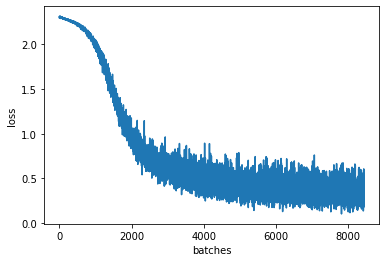

In [ ]:
import matplotlib.pyplot as plt 
batch_losses_val_y = [] 
for ele in batch_losses: 
  batch_losses_val_y.append(ele.item()) 
plt.plot(batch_losses_val_y)
plt.xlabel("batches")
plt.ylabel("loss")

#### Final Test Accuracy 

In [ ]:
def final(num_epochs, lr, weight_decay, train_data, test_data): 
  batch_losses, trained_model, loss_function = train_function_hyperparameters(num_epochs, train_data, lr, weight_decay) 
  predicted_val, actual_val = test_function(test_data, trained_model, loss_function) 
  accuracy_val = accuracy(predicted_val, actual_val) 

  return accuracy_val, batch_losses 

# split train into train and validation 
val_ratio = 0.1 
train_data, val_data = torch.utils.data.random_split(trainset, (int(len(trainset)*(1-val_ratio)), int(len(trainset)*val_ratio)))
test_data = testset 

# train model 
num_epochs = 30 
lr = 0.027820 
weight_decay = 3.3622e-05
accuracy_val, batch_losses = final(num_epochs, lr, weight_decay, train_data, test_data)
print('accuracy: {}'.format(accuracy_val))

Epoch: 0 | Loss: 0.40981557965278625

Epoch: 1 | Loss: 0.25484058260917664

Epoch: 2 | Loss: 0.11916176229715347

Epoch: 3 | Loss: 0.19158776104450226

Epoch: 4 | Loss: 0.15766291320323944

Epoch: 5 | Loss: 0.388403981924057

Epoch: 6 | Loss: 0.2933134138584137

Epoch: 7 | Loss: 0.11501971632242203

Epoch: 8 | Loss: 0.08663450926542282

Epoch: 9 | Loss: 0.32671406865119934

Epoch: 10 | Loss: 0.12942694127559662

Epoch: 11 | Loss: 0.013431544415652752

Epoch: 12 | Loss: 0.07791896164417267

Epoch: 13 | Loss: 0.08211163431406021

Epoch: 14 | Loss: 0.18534673750400543

Epoch: 15 | Loss: 0.08186078816652298

Epoch: 16 | Loss: 0.15622536838054657

Epoch: 17 | Loss: 0.03590629622340202

Epoch: 18 | Loss: 0.04338592290878296

Epoch: 19 | Loss: 0.03713003918528557

Epoch: 20 | Loss: 0.16216008365154266

Epoch: 21 | Loss: 0.020043766126036644

Epoch: 22 | Loss: 0.0029382621869444847

Epoch: 23 | Loss: 0.11569424718618393

Epoch: 24 | Loss: 0.12287165969610214

Epoch: 25 | Loss: 0.02082220464944

Text(0, 0.5, 'loss')

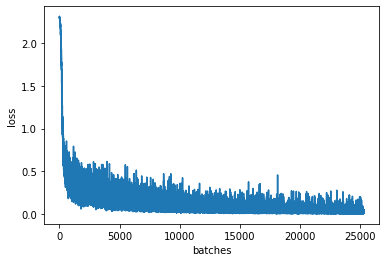

In [ ]:
import matplotlib.pyplot as plt 
batch_losses_val_y = [] 
for ele in batch_losses: 
  batch_losses_val_y.append(ele.item()) 
plt.plot(batch_losses_val_y)
plt.xlabel("batches")
plt.ylabel("loss")